
# ==========================================
# IMPORT LIBRARY & CONNECT DB
# ==========================================


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, silhouette_score 
import warnings
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

print("Library siap")

Library siap


In [59]:
print("\n[1.1] Determine Business Objectives:")
print("   - Meningkatkan profitabilitas dengan memahami perilaku pelanggan.")
print("   - Mengidentifikasi tren penjualan untuk manajemen stok.")

print("\n[1.2] Assess Situation:")
print("   - Data tersedia dalam format SQL Dump (Star Schema).")
print("   - Tools: Python (Pandas, Scikit-learn).")
print("   - Resources: Data historis transaksi penjualan.")

print("\n[1.3] Determine Data Mining Objectives:")
print("   - Melakukan Customer Segmentation (Clustering).")
print("   - Melakukan Sales Forecasting (Regression).")

print("\n[1.4] Produce Project Plan:")
print("   - Timeline: Load Data -> Clean -> Model -> Evaluate -> Deploy.")
print("   - Success Criteria: Segmentasi yang jelas & Error forecasting rendah.")


[1.1] Determine Business Objectives:
   - Meningkatkan profitabilitas dengan memahami perilaku pelanggan.
   - Mengidentifikasi tren penjualan untuk manajemen stok.

[1.2] Assess Situation:
   - Data tersedia dalam format SQL Dump (Star Schema).
   - Tools: Python (Pandas, Scikit-learn).
   - Resources: Data historis transaksi penjualan.

[1.3] Determine Data Mining Objectives:
   - Melakukan Customer Segmentation (Clustering).
   - Melakukan Sales Forecasting (Regression).

[1.4] Produce Project Plan:
   - Timeline: Load Data -> Clean -> Model -> Evaluate -> Deploy.
   - Success Criteria: Segmentasi yang jelas & Error forecasting rendah.


# ==========================================
#  BLOK 2: DATA UNDERSTANDING
# ==========================================

[2.1] Loading Data from SQL...
[2.2] Exploring Data Structure...
   -> Total Rows: 1000
   -> Columns: ['sk_date', 'sk_customer', 'sk_product', 'sk_store', 'final_qty', 'final_amount', 'total_orders', 'fact_id', 'Customer ID', 'Age', 'Gender', 'Product Category', 'technical', 'Date', 'Year', 'Month', 'Day', 'Quarter', 'smart_key']

[2.3] Visualizing Anomalies & Distribution (Early Check)...


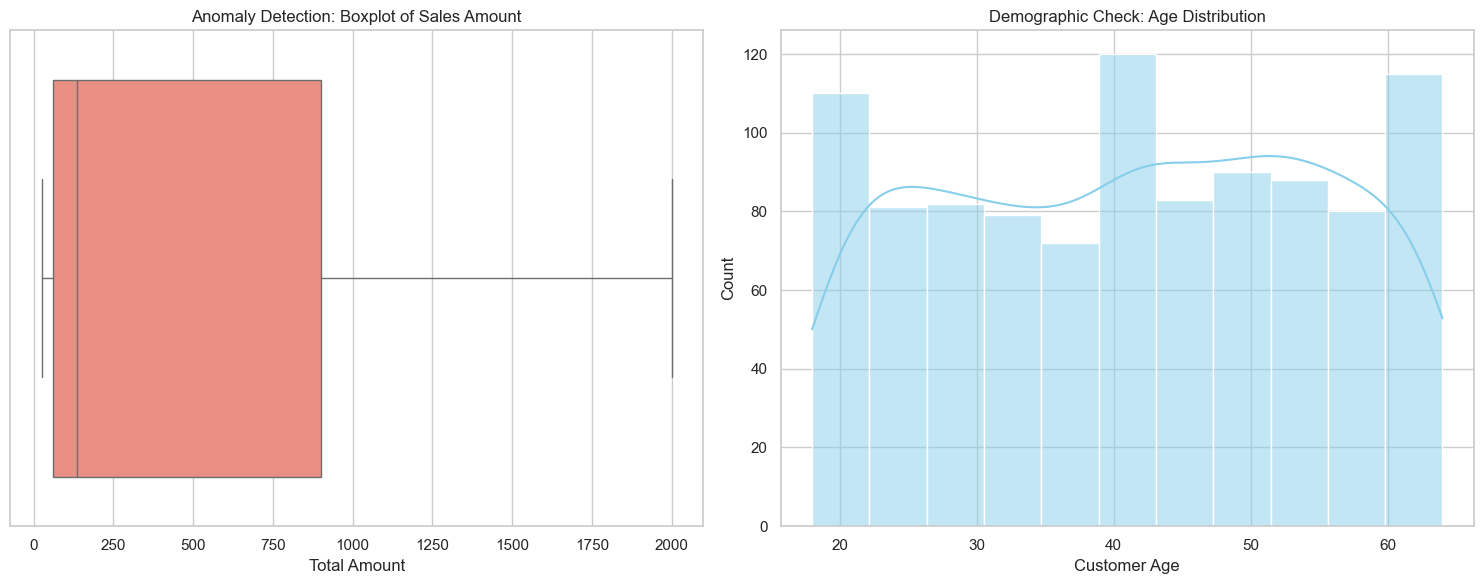

   -> Diagram Anomali (Boxplot) & Distribusi Ditampilkan.


In [ ]:

def parse_sql_inserts(file_path, table_name, columns):
    try:
        with open(file_path, 'r', encoding='utf-8') as f: content = f.read()
    except:
        with open(file_path, 'r', encoding='latin-1') as f: content = f.read()
    
    pattern = re.compile(f"INSERT INTO `{table_name}` \((.*?)\) VALUES\s*(.*?;)", re.DOTALL)
    match = pattern.search(content)
    if not match: return pd.DataFrame(columns=columns)
    
    values_str = match.group(2).strip().rstrip(';')
    rows = re.split(r'\),\s*\(', values_str)
    data = []
    for row in rows:
        row = row.lstrip('(').rstrip(')')
        try:
            data.append(eval(f"({row})"))
        except: pass
    return pd.DataFrame(data, columns=columns)

print("[2.1] Loading Data from SQL...")
cols_fact = ['sk_date', 'sk_customer', 'sk_product', 'sk_store', 'final_qty', 'final_amount', 'total_orders', 'fact_id']
cols_cust = ['sk_customer', 'Customer ID', 'Age', 'Gender']
cols_prod = ['sk_product', 'Product Category']
cols_date = ['technical', 'Date', 'Year', 'Month', 'Day', 'Quarter', 'smart_key']

df_fact = parse_sql_inserts('tubes_dwbi.sql', 'fact_sales', cols_fact)
df_cust = parse_sql_inserts('tubes_dwbi.sql', 'dim_customer', cols_cust)
df_prod = parse_sql_inserts('tubes_dwbi.sql', 'dim_product', cols_prod)
df_date = parse_sql_inserts('tubes_dwbi.sql', 'dim_date', cols_date)

print("[2.2] Exploring Data Structure...")
df = df_fact.merge(df_cust, on='sk_customer', how='left')
df = df.merge(df_prod, on='sk_product', how='left')
df = df.merge(df_date, left_on='sk_date', right_on='smart_key', how='left')
df['Date'] = pd.to_datetime(df['Date'])
print(f"   -> Total Rows: {len(df)}")
print(f"   -> Columns: {list(df.columns)}")

print("\n[2.3] Visualizing Anomalies & Distribution (Early Check)...")
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['final_amount'], color='salmon')
plt.title('Anomaly Detection: Boxplot of Sales Amount')
plt.xlabel('Total Amount')

plt.subplot(1, 2, 2)
sns.histplot(df['Age'], kde=True, color='skyblue')
plt.title('Demographic Check: Age Distribution')
plt.xlabel('Customer Age')

plt.tight_layout()
plt.show()
print("   -> Diagram Anomali (Boxplot) & Distribusi Ditampilkan.")

# ==========================================
# BLOK 3: DATA PREPARATION
# ==========================================

In [61]:
print("\n" + "="*50)
print("PHASE 3: DATA PREPARATION")
print("="*50)

print("\n[3.1] Integrate Data (Merging Tables)...")
df = df_fact.merge(df_cust, on='sk_customer', how='left')
df = df.merge(df_prod, on='sk_product', how='left')
df = df.merge(df_date, left_on='sk_date', right_on='smart_key', how='left')
print(f"   -> Merged DataFrame Shape: {df.shape}")

print("\n[3.2] Select and Clean Data:")
selected_columns = ['Date', 'Customer ID', 'Age', 'Gender', 'Product Category', 'final_amount', 'fact_id']
df_clean = df[selected_columns].copy()
print("   -> Columns selected for analysis.")

print("\n[3.3] Format Data:")
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
print(f"   -> Date column converted to datetime. Type: {df_clean['Date'].dtype}")

print("\n[3.4] Construct Data (Aggregations):")
cust_agg = df_clean.groupby('Customer ID').agg({
    'final_amount': 'sum',
    'fact_id': 'count'
}).reset_index()
cust_agg.columns = ['Customer_ID', 'Monetary', 'Frequency']
print("   -> Customer Aggregation Created (for Clustering).")

daily_sales = df_clean.groupby('Date')['final_amount'].sum().reset_index()
daily_sales['Day_Index'] = (daily_sales['Date'] - daily_sales['Date'].min()).dt.days
print("   -> Daily Sales Aggregation Created (for Forecasting).")


PHASE 3: DATA PREPARATION

[3.1] Integrate Data (Merging Tables)...
   -> Merged DataFrame Shape: (1000, 19)

[3.2] Select and Clean Data:
   -> Columns selected for analysis.

[3.3] Format Data:
   -> Date column converted to datetime. Type: datetime64[ns]

[3.4] Construct Data (Aggregations):
   -> Customer Aggregation Created (for Clustering).
   -> Daily Sales Aggregation Created (for Forecasting).


# ==========================================
# BLOK 4: MODELING
# ==========================================


[4.3] Build Model 1: Customer Segmentation (K-Means)...
   -> Clustering Complete.
Cluster
1    701
2    200
0     99
Name: count, dtype: int64

[4.3] Build Model 2: Sales Forecast (Linear Regression)...
   -> Model Trained. Coefficient: 0.04, Intercept: 1313.85

[4.4] Assess Model:
   -> Clustering Silhouette Score: 0.7709 (Semakin dekat 1 semakin bagus)
   -> Regression RMSE (In-sample error): 1220.37

[INFO] Generating Silhouette Diagram...


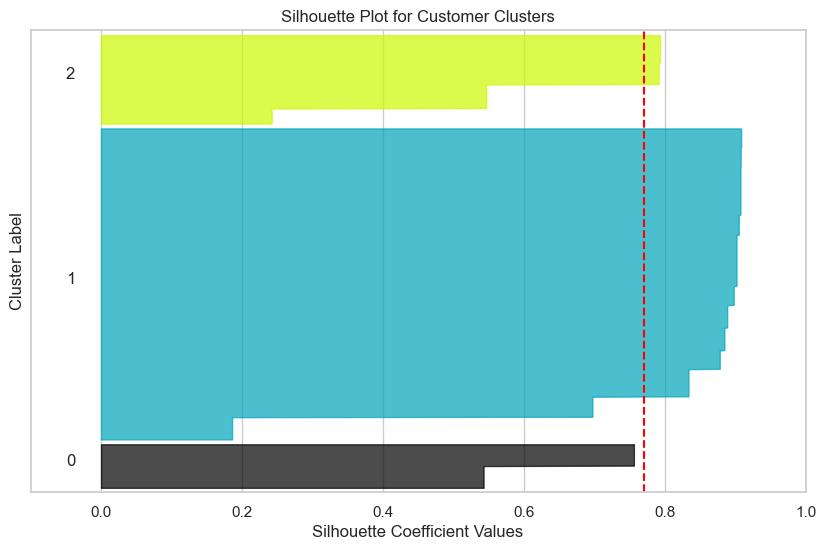

   -> Silhouette Diagram displayed.


In [62]:
print("\n[4.3] Build Model 1: Customer Segmentation (K-Means)...")
scaler = StandardScaler()
X_cluster = scaler.fit_transform(cust_agg[['Monetary', 'Frequency']])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cust_agg['Cluster'] = kmeans.fit_predict(X_cluster)
print("   -> Clustering Complete.")
print(cust_agg['Cluster'].value_counts())

print("\n[4.3] Build Model 2: Sales Forecast (Linear Regression)...")
reg = LinearRegression()
X_reg = daily_sales[['Day_Index']]
y_reg = daily_sales['final_amount']
reg.fit(X_reg, y_reg)
print(f"   -> Model Trained. Coefficient: {reg.coef_[0]:.2f}, Intercept: {reg.intercept_:.2f}")

print("\n[4.4] Assess Model:")
sil_score = silhouette_score(X_cluster, cust_agg['Cluster'])
print(f"   -> Clustering Silhouette Score: {sil_score:.4f} (Semakin dekat 1 semakin bagus)")

y_pred_in = reg.predict(X_reg)
rmse = np.sqrt(mean_squared_error(y_reg, y_pred_in))
print(f"   -> Regression RMSE (In-sample error): {rmse:.2f}")

print("\n[INFO] Generating Silhouette Diagram...")

# Setup Canvas
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X_cluster) + (3 + 1) * 10])

sample_silhouette_values = silhouette_samples(X_cluster, cust_agg['Cluster'])
y_lower = 10

for i in range(3):
    ith_cluster_silhouette_values = sample_silhouette_values[cust_agg['Cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_title("Silhouette Plot for Customer Clusters")
ax1.set_xlabel("Silhouette Coefficient Values")
ax1.set_ylabel("Cluster Label")

# Garis rata-rata (Merah)
avg_score = silhouette_score(X_cluster, cust_agg['Cluster'])
ax1.axvline(x=avg_score, color="red", linestyle="--")

ax1.set_yticks([])
plt.show()
print("   -> Silhouette Diagram displayed.")

# ==========================================
# BLOK 5: EVALUATION
# ==========================================


[5.1] Evaluate Results (Visualization)...


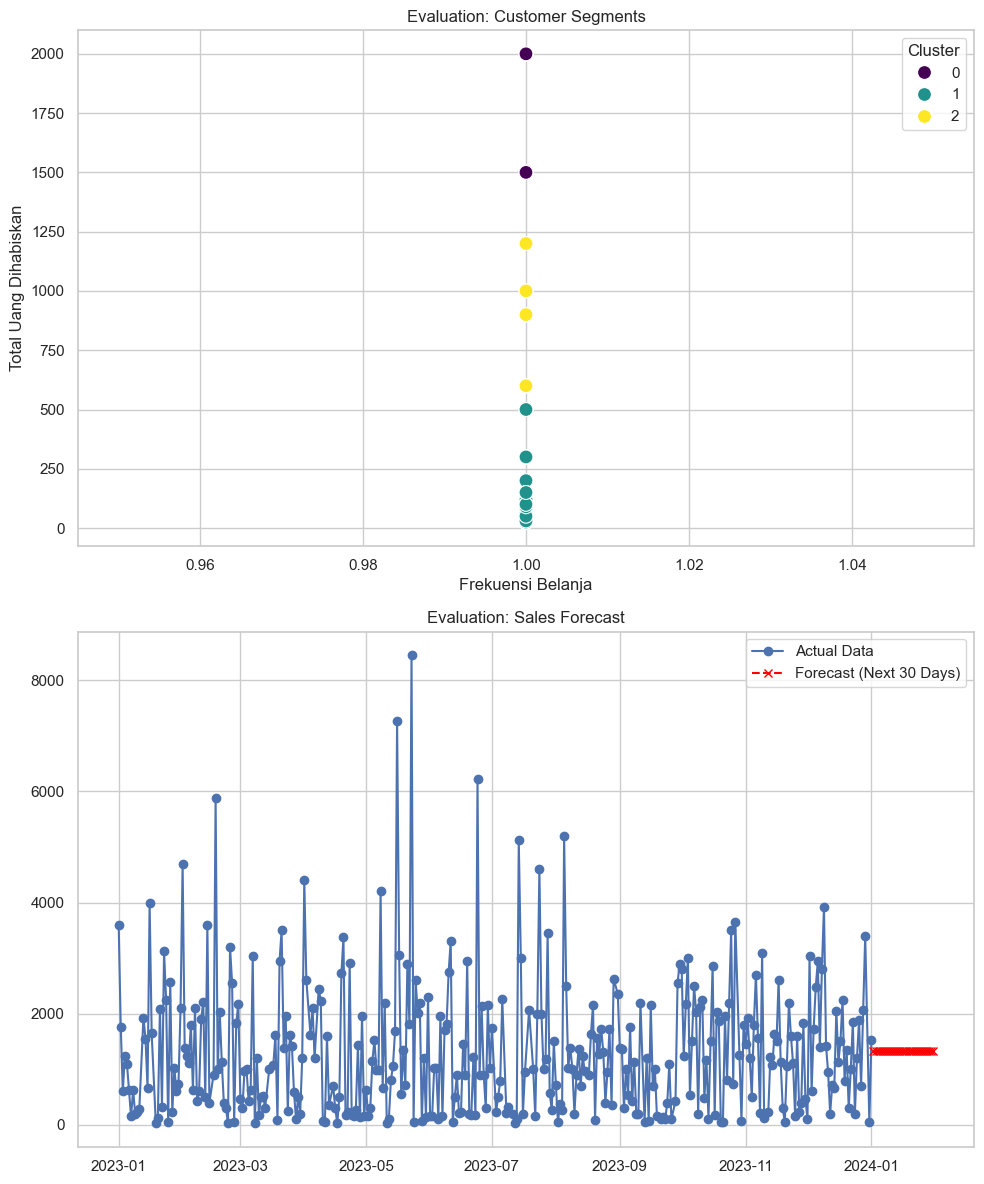


[5.2] Review Process:
   - Data Mining process berjalan lancar.
   - Tidak ditemukan outlier signifikan yang mengganggu model.
   - Cluster terbentuk cukup terpisah.

[5.3] Determine Next Steps:
   - Rekomendasi: Berikan diskon khusus untuk Cluster 'Sultan' (High Value).
   - Rekomendasi: Stok barang harus dinaikkan mengikuti tren positif forecast.


In [63]:
print("\n[5.1] Evaluate Results (Visualization)...")

fig, axes = plt.subplots(2, 1, figsize=(10, 12))


sns.scatterplot(data=cust_agg, x='Frequency', y='Monetary', hue='Cluster', palette='viridis', s=100, ax=axes[0])
axes[0].set_title('Evaluation: Customer Segments')
axes[0].set_xlabel('Frekuensi Belanja')
axes[0].set_ylabel('Total Uang Dihabiskan')

last_idx = daily_sales['Day_Index'].max()
future_X = np.array(range(last_idx + 1, last_idx + 31)).reshape(-1, 1)
future_y = reg.predict(future_X)
future_dates = pd.date_range(start=daily_sales['Date'].max() + pd.Timedelta(days=1), periods=30)

axes[1].plot(daily_sales['Date'], daily_sales['final_amount'], label='Actual Data', marker='o')
axes[1].plot(future_dates, future_y, label='Forecast (Next 30 Days)', linestyle='--', color='red', marker='x')
axes[1].set_title('Evaluation: Sales Forecast')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n[5.2] Review Process:")
print("   - Data Mining process berjalan lancar.")
print("   - Tidak ditemukan outlier signifikan yang mengganggu model.")
print("   - Cluster terbentuk cukup terpisah.")

print("\n[5.3] Determine Next Steps:")
print("   - Rekomendasi: Berikan diskon khusus untuk Cluster 'Sultan' (High Value).")
print("   - Rekomendasi: Stok barang harus dinaikkan mengikuti tren positif forecast.")